# Implementation of Machine Learning Algorithms on Titanic Survivor Dataset (Classification Task)
This notebook implements some Machine Learning classification algorithms as well as discusses bias / variance trade-off and underfitting / overfitting using Learning and Validation curves on the Titanic Survivor Dataset. The dataset has been provided by Kaggle. https://www.kaggle.com/c/titanic/data

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler
from Utils import *
from LogisticRegression import LogisticRegression
from KNN import KNN
from NaiveBayes import NaiveBayes
from ImputationTransform import ImputationTransform
%matplotlib inline

## 1. Logistic Regression
We begin by first implementing logistic regression.

In [78]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=True, normalize_data=True)
print("updated train data size (without label)", train_X.shape)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


### Gradient Descent
Below, we see the effect of varying learning rate on Gradient Descent Algorithm. As learning rate increases, the convergence is reached faster - i.e. at earlier iteration. Looking at this graph, we can verify that our implementation of Gradient Descent is working as expected.

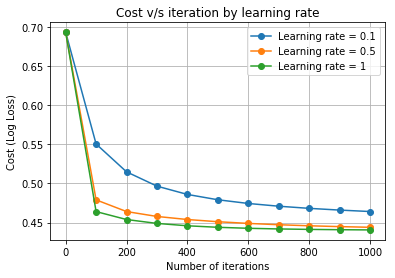

<Figure size 432x288 with 0 Axes>

In [62]:
learning_rate = [0.1,0.5,1]
max_iter = 1000
iteration_threshold = 100

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                           regularization="Ridge")

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost (Log Loss)", plotlabels=plotlabels)

### Analysis
#### Learning Curves
Now, we move on to analyze if logistic regression with our set of features is a 'good' algorithm for this dataset. Specifically, we will look for evidence of underfitting (high bias) or overfitting (high variance) by plotting the learning curve, i.e. measuring accuracy on training and a held out validation set with varying size of training data.  

In [80]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('logReg', LogisticRegression(learning_rate=1, cost_threshold=0.00001))]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


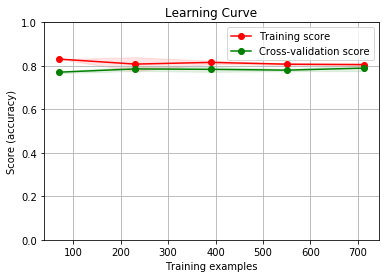

<Figure size 432x288 with 0 Axes>

In [81]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve", X=train_X, y=train_y, ylim=(0, 1), cv=cv, 
                    train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy")

Looking at the above curve, we can see that increasing dataset size is not improving the accuracy on the validation set. The performance on training and validation set is very close to each other. We suffer from a 'high bias' or underfitting problem. In other words, either the algorithm or the features are too simplistic to achieve good training and validation performance.

#### Validation Curves
The learning curve from above suggests that we have a 'high bias' problem. This should mean that increasing strength of regularization should not help much in achieving higher validation set performance because regularization further increases the bias. Here, we plot the validation curve - i.e. vary hyperparameter strength of regularization and measure the accuracy.

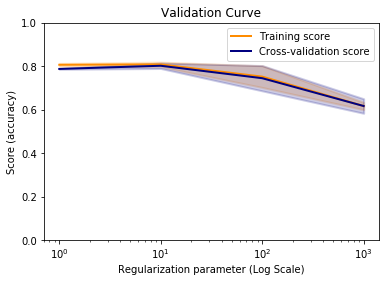

<Figure size 432x288 with 0 Axes>

In [65]:
param_range = [1, 10, 100, 1000]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve", X=train_X, y=train_y, 
    param_name="logReg__reg_strength", param_range=param_range, cv=3, scoring="accuracy", 
    ylim=(0, 1))

#### Grid Search
As predicted by the analysis of learning curve, increasing strength of regularization only slightly improves the performance. We will do a fine tuned grid search below to find the best hyperparameter. Looking at the results, we find that for the given set of features, a logistic regression model with regularization parameter value of 35 performs best on the validation set. To improve the model performance, we will either have to use a more complex algorithm or more complex set of features.

In [83]:
param_values = [0, 1, 3, 10, 15, 20, 25, 27, 28, 30, 35, 38, 40]
param_grid = dict(logReg__reg_strength=param_values)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, 
                           return_train_score=True)

grid_search.fit(train_X, train_y)

print("Regularization param values: " + str(param_values))
print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))
print("Best test score: " + str(max(grid_search.cv_results_['mean_test_score'])))

Regularization param values: [0, 1, 3, 10, 15, 20, 25, 27, 28, 30, 35, 38, 40]
Mean train scores: [0.80920314 0.80527497 0.80022447 0.80808081 0.80695847 0.81088664
 0.81144781 0.81144781 0.81200898 0.81144781 0.81144781 0.80695847
 0.80078563]
Mean test scores: [0.78900112 0.78675645 0.78338945 0.80022447 0.80246914 0.80695847
 0.81144781 0.81144781 0.81144781 0.81144781 0.81144781 0.80808081
 0.80022447]
Best test score: 0.8114478114478114


#### Prediction on test data
Here, we have the code to predict test labels using best performing model found in the previous step (Grid search). We finally write the output to a file.

In [67]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

test_X, test_y = preprocess(test, impute_data=False, normalize_data=False, is_train=False)
print("updated test data size (without label)", test_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('logReg', LogisticRegression(learning_rate=1, cost_threshold=0.00001))]
pipeline = Pipeline(estimators)

# set regularization strength
pipeline.set_params(logReg__reg_strength=35).fit(train_X, train_y)

prediction = pipeline.predict(test_X)

test_y = test_y.reshape((test_y.shape[0],))

d = {'PassengerId': test_y, 'Survived': prediction}

pred_df = pd.DataFrame(data=d)

write_to_file(pred_df, 'logreg_test.csv', sep=',')

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)
updated test data size (without label) (418, 10)


## 2. k-Nearest Neighbor Classification
We now move onto implementing k-Nearest Neighbor Classification on the given dataset.

In [84]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('kNN', KNN())]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


#### Learning Curves
Learning curve for kNN algorithm with k=1 indicates slight evidence of overfitting (high variance). Model performance improves with increase in the training data size. Alternatively, model performance should also improve with decreasing variance by increasing number of nearest neighbors (k) - this will be verified through plotting validation curve. We can notice that accuracy is not 100% even on the training set with k=1. This is the case because there are training examples in the dataset for which all features are same but label is different, i.e. for some training examples, there are multiple neighbors with same distance of 0.

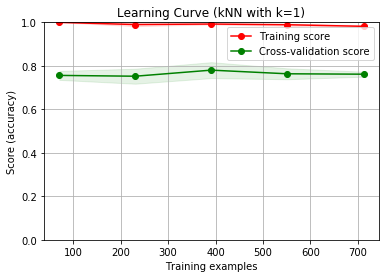

<Figure size 432x288 with 0 Axes>

In [69]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (kNN with k=1)", X=train_X, y=train_y, 
                    ylim=(0, 1), cv=cv, train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy")

#### Validation Curves
The learning curve above indicates slight evidence of overfitting - so we would expect increasing number of nearest neighbors to increase model performance. Indeed, we find that k=9 performs better on the validation set than k=1. We can also see that both training and validation scores are closer to each other at k=9.

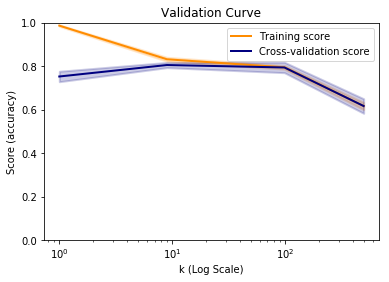

<Figure size 432x288 with 0 Axes>

In [70]:
param_range = [1, 9, 99, 499]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve", X=train_X, y=train_y, 
    param_name="kNN__k", param_range=param_range, cv=3, scoring="accuracy", 
    ylim=(0, 1), xlabel="k")

#### Grid Search
As predicted by the analysis of learning curve, increasing k improves the performance. We will do a fine tuned grid search below to find the best hyperparameter. Looking at the results, we find that for the given set of features, kNN algorithm with k=17 performs best on the validation set.

In [85]:
param_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
param_grid = dict(kNN__k=param_values)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, 
                           return_train_score=True)

grid_search.fit(train_X, train_y)

print("Regularization param values: " + str(param_values))
print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))
print("Best test score: " + str(max(grid_search.cv_results_['mean_test_score'])))

Regularization param values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
Mean train scores: [0.98597082 0.88215488 0.85521886 0.84231201 0.83108866 0.828844
 0.82379349 0.81593715 0.81593715 0.81705948]
Mean test scores: [0.75196409 0.78451178 0.78563412 0.8013468  0.8047138  0.79349046
 0.79573513 0.79910213 0.80583614 0.8047138 ]
Best test score: 0.8058361391694725


## 3. Naive Bayes Classification
We now move onto implementing Naive Bayes Classification on the given dataset. Here, we have combined the Gaussian Naive Bayes and Bernoulli Naive Bayes implementations from scikit learn as we have both binary and continuous features in the dataset.

Here is an example of Naive Bayes algorithm for this dataset. The probability of being a survivor needs to be calculated given a training example. The classifier will predict survival if survival probability is higher than non-survival. 

P(survivor | data[gender=male, age=20, etc.]) = P(gender=male | survivor) * P(age=20 | survivor) * P(survivor) / P(data) 

P(non-survivor | data[gender=male, age=20, etc.]) = P(gender=male | non-survivor) * P(age=20 | non-survivor) * P(non-survivor) / P(data)

Since, P(data) is present as denominator in both the classes, it can be ignored for the purposes of making a decision.

Also, P(gender=male | survivor) is evaluated based on counts of male survivors divided by total survivors. For continuous feature like age, gaussian PDF is assumed and probability of age being 20 given survivor is estimated using Gaussian PDF by first estimating mean and variance for both survivor and non-survivor classes.

In [73]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
train_y = train_y.reshape((train_y.shape[0],))
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('NB', NaiveBayes())]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


#### Learning Curves
Learning curve for Naive Bayes algorithm indicates slight overfitting initially but eventually increasing the training data size is not increasing model performance. It seems that we are in the 'high-bias' regime and changing strength of laplace smoothing should not help much with performance. We will check this while plotting the validation curves.

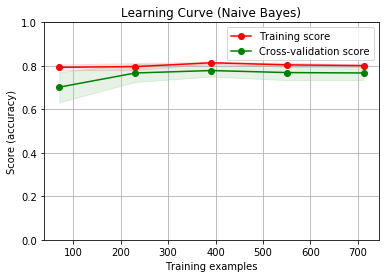

<Figure size 432x288 with 0 Axes>

In [11]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (Naive Bayes)", X=train_X, y=train_y, 
                    ylim=(0, 1), cv=cv, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy")

#### Validation Curves
The learning curve above does not indicate overfitting - so we would expect strength of laplace smoothing to not increase model performance by much. Indeed, we find that until strength of laplace smoothing of 10, there is no improvement in performance and at 100 the performance worsens.

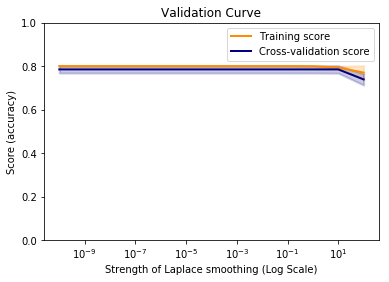

<Figure size 432x288 with 0 Axes>

In [6]:
param_range = [1e-10, 1e-7, 1e-4, 1e-1, 1, 10, 100]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve", X=train_X, y=train_y, 
    param_name="NB__laplace_smoothing", param_range=param_range, cv=3, scoring="accuracy", 
    ylim=(0, 1), xlabel="Strength of Laplace smoothing")

## 4. Support Vector Machine
Next, we run the scikit learn implementation of Support Vector Machines. We experiment with both linear and kernelized implementations. SVMs aim at maximizing margin among the vectors nearest to the decision boundary (support vectors). Kernelized SVMs convert the points from lower dimension to higher dimensional space by computing pairwise similarity between points (similarity function is called kernel). This helps with data that are not linearly separable (datapoints that are not linearly separable in lower dimensional space - but are separable in high-dimension space).

In [86]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
train_y = train_y.reshape((train_y.shape[0],))
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), ('LinSVM', LinearSVC(C=1, max_iter=1000000))]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


#### Learning Curves and Grid Search
Learning curve for linear SVM seems to indicate slight underfitting. We might be able to perform better using RBF Kernel SVM.

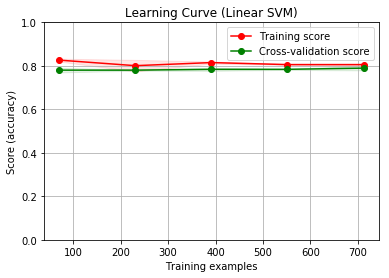

<Figure size 432x288 with 0 Axes>

In [89]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (Linear SVM)", X=train_X, y=train_y, 
                    ylim=(0, 1), cv=cv, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy")

In [88]:
param_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(LinSVM__C=param_values)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, 
                           return_train_score=True)

grid_search.fit(train_X, train_y)

print("Regularization param values: " + str(param_values))
print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))
print("Best test score: " + str(max(grid_search.cv_results_['mean_test_score'])))

Regularization param values: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Mean train scores: [0.67227834 0.80190797 0.79910213 0.80527497 0.80527497 0.80527497
 0.80527497]
Mean test scores: [0.67227834 0.78002245 0.78900112 0.79124579 0.79124579 0.79124579
 0.79124579]
Best test score: 0.7912457912457912


In [75]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
train_y = train_y.reshape((train_y.shape[0],))
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), ('RBFSVM', SVC(C=1, gamma='auto', max_iter=1000000))]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


Below, we show the learning curve for SVM with RBF kernel as well. Although the figure does not show much improvement in performance, we can see (in the grid search results below the learning curve) that RBF SVM achieves the best model performance (82.38% accuracy) amongst all algorithms considered. Here, in addition to C (regularization parameter), there is another parameter gamma which controls bias / variance tradeoff. Larger values of C and gamma indicate lower strength of regularization. Gamma is inverse of the value of 'variance' of Gaussian similarity function (RBF kernel). So, higher value implies lower similarity amongst training data points. In this case, learning will be sensitive to outliers. Note, that this 'variance' of similarity function is not same as 'variance' in the bias / variance tradeoff. 

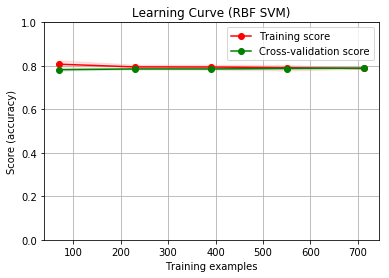

<Figure size 432x288 with 0 Axes>

In [76]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (RBF SVM)", X=train_X, y=train_y, 
                    ylim=(0, 1), cv=cv, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy")

In [77]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(RBFSVM__C=C_values, RBFSVM__gamma=gamma_values)
# grid search with multiple params
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, 
                           return_train_score=True)


grid_search.fit(train_X, train_y)

print("Best test score: " + str(max(grid_search.cv_results_['mean_test_score'])))
print("Best params: " + str(grid_search.best_params_))

Best test scores: 0.8237934904601572
Best params: {'RBFSVM__C': 1000, 'RBFSVM__gamma': 0.1}
